* Gender — пол пассажира (женский, мужской);
* Customer Type — тип клиента (постоянный/непостоянный клиент);
* Age — возраст клиента;
* Type of Travel — цель перелета (личная/деловая поездка);
* Class — туристический класс пассажира (Business, Eco, Eco Plus);
* Flight distance — расстояние полета;
* Inflight wifi service — уровень удовлетворённости Wi-Fi (0 — не применимо, 1–5);
* Departure/Arrival time convenient — уровень удовлетворённости временем отправления и прибытия;
* Ease of Online booking — уровень удовлетворённости онлайн-бронированием;
* Gate location — уровень удовлетворённости расположением выхода на посадку;
* Food and drink — уровень удовлетворённости едой и напитками;
* Online boarding — уровень удовлетворённости онлайн-регистрацией;
* Seat comfort — уровень удовлетворённости комфортом сидений;
* Inflight entertainment — уровень удовлетворённости развлечениями на борту;
* On-board service — уровень удовлетворённости сервисом на борту;
* Leg room service — уровень удовлетворённости местом для ног;
* Baggage handling — уровень удовлетворённости обработкой багажа;
* Check-in service — уровень удовлетворённости услугами регистрации;
* Inflight service — уровень удовлетворённости обслуживанием во время полёта;
* Cleanliness — уровень удовлетворённости чистотой;
* Departure Delay in Minutes — задержка при отправлении (в минутах);
* Arrival Delay in Minutes — задержка при прибытии (в минутах);
* Satisfaction — удовлетворённость авиакомпанией — целевая переменная (satisfaction/neutral/dissatisfaction).

In [47]:
# !pip install xgboost
# !pip install catboost

In [82]:
import pandas as pd
import numpy as np
# # Графика
import matplotlib.pyplot as plt
import seaborn as sns
# Деление выборки
from sklearn import model_selection

from sklearn import preprocessing #предобработка данных
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble # онсамбли
import xgboost as xgb
import catboost as cat

from sklearn.metrics import f1_score, make_scorer #метрики

In [49]:
Air_data = pd.read_csv('../../data/AirPass.csv',index_col='Unnamed: 0')
Air_data.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [50]:
# Air_data.info()

### Задание 6.1
Для начала сделаем небольшую предобработку данных. Сколько всего в данных пропущенных значений?

In [51]:
print(Air_data.isnull().sum().sum(),': суммарно пропусков в данных')

310 : суммарно пропусков в данных


In [52]:
# Air_data.isnull().sum()

### Задание 6.2
Теперь давайте избавимся от найденных пропусков. Заполните их все медианными значениями. После этого вычислите среднее арифметическое для признака, отражающего задержку при прибытии в минутах. Ответ округлите до двух знаков после точки-разделителя.

In [53]:
# Arrival Delay in Minutes
Air_data['Arrival Delay in Minutes'] = Air_data['Arrival Delay in Minutes'].fillna(Air_data['Arrival Delay in Minutes'].median())
round(Air_data['Arrival Delay in Minutes'].mean(),2)

15.13

### Задание 6.3
Проведём небольшой разведывательный анализ. Посмотрим, в каких категориях пассажиров превалировали удовлетворённые полетом клиенты.

In [54]:
# Air_data['satisfaction'].value_counts()
# neutral or dissatisfied    58879   нейтральный или недовольный
# satisfied                  45025   удовлетворенный

#### 1. Сравните удовлетворённость полётом мужчин и женщин. Выберите верное утверждение:

Gender,Female,Male
satisfaction,,
neutral or dissatisfied,30193,28686
satisfied,22534,22491


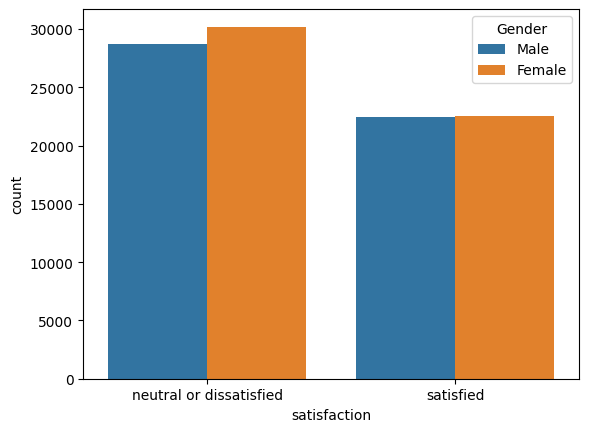

In [55]:
temp=Air_data.groupby('satisfaction')['Gender'].value_counts()

temp=Air_data.pivot_table(index ='satisfaction',columns ='Gender', values ='id',aggfunc ='count')
display(temp)
sns.countplot(data=Air_data, x='satisfaction', hue ='Gender');

#### 2. Теперь сравним категории пассажиров в зависимости от их цели поездки. Выберите все верные утверждения:

Type of Travel,Business travel,Personal Travel
satisfaction,,
neutral or dissatisfied,29909,28970
satisfied,41746,3279


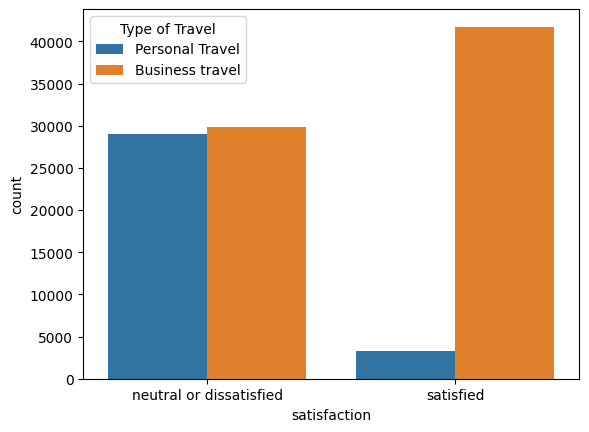

In [56]:
temp=Air_data.pivot_table(index ='satisfaction',columns ='Type of Travel', values ='id',aggfunc ='count')
display(temp)
sns.countplot(data=Air_data, x='satisfaction', hue ='Type of Travel');
# Business travel  Деловые поездки
# Personal Travel  Личные поездки

#### 3. В каком туристическом классе наибольший процент довольных клиентов?

Class,Business,Eco,Eco Plus
satisfaction,,,
neutral or dissatisfied,15185,38044,5650
satisfied,34480,8701,1844


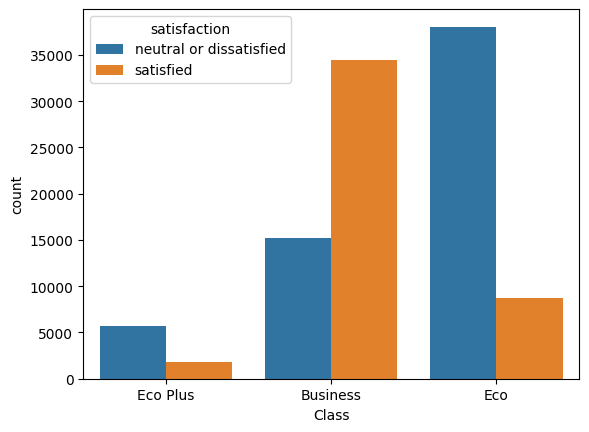

In [57]:
temp=Air_data.pivot_table(index ='satisfaction',columns ='Class', values ='id',aggfunc ='count')
display(temp)
sns.countplot(data=Air_data, hue ='satisfaction', x ='Class');

In [58]:
Air_data['satisfaction'] = Air_data['satisfaction'].map({'neutral or dissatisfied':0 , 'satisfied':1})
Air_data['Customer Type'] = Air_data['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
Air_data['Type of Travel'] = Air_data['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})
Air_data['Gender'] = Air_data['Gender'].map({'Male': 0, 'Female': 1})

### Задание 6.4
Для остальных категориальных признаков создайте dummy-переменные. Сделайте это с помощью функции get_dummies() из библиотеки Pandas, параметры не меняйте. Сколько теперь признаков в данных (включая целевую переменную)?

In [59]:
Air_data=pd.get_dummies(Air_data, columns=['Class'], prefix_sep='_')# columns=['Class'],
print(Air_data.shape[1], ' теперь признаков в данных')

26  теперь признаков в данных


### Задание 6.5
Мы практически добрались до обучения модели. Разбейте данные на обучающую и тестовую выборки в соотношении 80/20, параметр random_state = 26. Сколько наблюдений попало в тестовую выборку?

In [60]:
X = Air_data.drop('satisfaction', axis=1)
y = Air_data['satisfaction']
# Формируем обучающую и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=26) # , stratify=y
print(y_test.shape[0],' наблюдений попало в тестовую выборку')

20781  наблюдений попало в тестовую выборку


### Задание 6.6
Теперь нам необходимо реализовать масштабирование данных. Для этого обучите на обучающей выборке метод StandardScaler() и с помощью него преобразуйте и обучающую, и тестовую выборки. Не забудьте, что целевую переменную обрабатывать не нужно.

>Примечание. Отметим, что если бы дальше мы работали только с деревьями, масштабирование бы не требовалось. Однако мы реализуем его, чтобы можно было обучать и другие модели и сравнивать полученные результаты.

В качестве ответа введите самое первое значение из матрицы преобразованных признаков тестовой выборки. Округлите значение до двух знаков после точки-разделителя.

In [61]:
# StandardScaler подходит для нормально распределённых данных. Он сохраняет исходное распределение и не меняет форму, но чувствителен к выбросам и не подходит для данных с негауссовским распределением. 1
# MinMaxScaler масштабирует признаки в заданный диапазон, сохраняя взаимосвязи. Он не искажает исходное распределение, но чувствителен к выбросам и не эффективно обрабатывает данные с крайними выбросами. 1
# RobustScaler эффективно работает с данными с выбросами. 14 Для масштабирования он использует медиану и межквартильный диапазон, что позволяет обрабатывать признаки с большим количеством выбросов без влияния на них.
# Так как имеются выбросы применим RobustScaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
display(scaler)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Параметры выборки после трансформации')
print(round(X_test_scaled[0,0],2), ' самое первое значение из матрицы преобразованных признаков тестовой выборки')

StandardScaler()

Параметры выборки после трансформации
0.94  самое первое значение из матрицы преобразованных признаков тестовой выборки


### Задание 6.7
Перейдём к обучению моделей. В качестве первой модели возьмём самую простую — логистическую регрессию. Мы делаем это для того, чтобы потом сравнивать с ней полученные результаты: так вы сможете выяснить, насколько ансамбли смогут улучшить точность прогноза.

Обучите логистическую регрессию с параметрами по умолчанию на наших данных. В качестве ответа введите значение метрики f1_score. Ответ округлите до трёх знаков после точки-разделителя.

In [62]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression()
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
y_test_pred = log_reg.predict(X_train_scaled)
acc_le=f1_score(y_train, y_test_pred)
print('f1_score на Test: {:.3f}'.format(acc_le))

y_test_pred = log_reg.predict(X_test_scaled)
acc_le=f1_score(y_test, y_test_pred)
print('f1_score на Test: {:.3f}'.format(acc_le))

f1_score на Test: 0.854
f1_score на Test: 0.855


### Задание 6.8
Теперь перейдём к бустингу. Начнём с обучения первой модели — AdaBoost. В качестве базовой модели для неё возьмите решающее дерево с параметром random_state = 26.

Обучите AdaBoost, зафиксировав random_state со значением 26 и задав темп обучения 0.01. В качестве ответа введите значение метрики f1_score. Ответ округлите до трёх знаков после точки-разделителя.

In [63]:
#Создаем объект класса AdaBoost
eABC = ensemble.AdaBoostClassifier(estimator=tree.DecisionTreeClassifier(random_state=26),
                                   learning_rate=0.01,
                                   random_state=26)
#Обучаем модель, минимизируя AdaBoost
eABC.fit(X_train_scaled, y_train)
y_test_pred = eABC.predict(X_train_scaled)
acc_le=f1_score(y_train, y_test_pred)
print('f1_score на Test: {:.3f}'.format(acc_le))

y_test_pred = eABC.predict(X_test_scaled)
acc_le=f1_score(y_test, y_test_pred)
print('f1_score на Test: {:.3f}'.format(acc_le))

f1_score на Test: 1.000
f1_score на Test: 0.940


### Задание 6.9
Перейдем к следующему алгоритму — градиентному бустингу.

Будем настраивать количество деревьев и темп обучения, делая перебор по следующей сетке:

params = {"n_estimators":2**np.arange(8), "learning_rate":0.1**np.arange(3)}
Используйте для поиска оптимальных параметров GridSearchCV, а для ускорения работы алгоритма задайте параметр кросс-валидации, равный 3.

Какое наибольшее значение метрики f1_score получилось? Ответ округлите до трёх знаков после точки-разделителя.

>Примечание. Необходимо указать лучший результат в методе GridSearchCV на тренировочных данных.

In [76]:
params = {"n_estimators":2**np.arange(8), "learning_rate":0.1**np.arange(3)}

grid_search_rfc = model_selection.GridSearchCV(
    estimator=ensemble.GradientBoostingClassifier(), 
    param_grid=params, # словарь параметров для подбора
    verbose=2,# Контролирует детализацию 0, 1, 2, 3
    scoring=make_scorer(f1_score),
    cv=3, # валидация на 5 выборок
    n_jobs = -1 # все ядра процессора
)  
%time grid_search_rfc.fit(X_train_scaled, y_train) 
print("Наилучшие значения гиперпараметров: {} \n".format(grid_search_rfc.best_params_)) 
print("Лучшее значение метрики:", grid_search_rfc.best_score_)

y_pred_train = grid_search_rfc.predict(X_train_scaled)
print('f1_score на тренировочной выборке: {:.3f} \n'.format(f1_score(y_pred_train,y_train)))

y_pred_test = grid_search_rfc.predict(X_test_scaled)
print('f1_score на тестовой выборке: {:.3f}'.format(f1_score(y_pred_test, y_test)))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
CPU times: total: 49.9 s
Wall time: 5min 51s
Наилучшие значения гиперпараметров: {'learning_rate': 1.0, 'n_estimators': 128} 

Лучшее значение метрики: 0.9491819104267164
accuracy на тренировочной выборке: 0.961 

accuracy на тестовой выборке: 0.951


In [80]:
GBC=ensemble.GradientBoostingClassifier(learning_rate= 1.0, n_estimators= 128)
GBC.fit(X_train_scaled, y_train) 
y_pred_train = GBC.predict(X_train_scaled)
print('accuracy на тренировочной выборке: {:.3f} \n'.format(f1_score(y_pred_train,y_train)))

accuracy на тренировочной выборке: 0.961 



In [77]:
model_for_gs = ensemble.GradientBoostingClassifier()
params = {"n_estimators":2**np.arange(8), "learning_rate":0.1**np.arange(3)}
gs = model_selection.GridSearchCV(model_for_gs, 
                  params, 
                  cv=3, 
                  scoring=make_scorer(f1_score),
                  verbose=5,
                  n_jobs = -2)
 
gs.fit(X_train_scaled, y_train)
 
print("Лучшие гиперпараметры:", gs.best_params_)
print("Лучшее значение метрики:", gs.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Лучшие гиперпараметры: {'learning_rate': 1.0, 'n_estimators': 128}
Лучшее значение метрики: 0.9491271591690081


### Задание 6.10
Обучите алгоритм XGBoost. Так как он достаточно мощный «из коробки», определите его с параметрами по умолчанию, только задайте random_state = 26. Какое значение метрики f1_score получилось? Ответ округлите до трёх знаков после точки-разделителя.

>Подсказка. Для того чтобы обучить алгоритм XGBoost для решения задачи классификации, вам понадобится XGBClassifier из библиотеки xgboost, установленной ранее. Вся дальнейшая последовательность действий (обучение модели, предсказание, оценка качества) идентична другим алгоритмам, например логистической регрессии.

In [84]:
model = xgb.XGBClassifier(random_state = 26)
model.fit(X_train_scaled, y_train)

y_test_pred = model.predict(X_train_scaled)
acc_le=f1_score(y_train, y_test_pred)
print('f1_score на Train: {:.3f}'.format(acc_le))

y_test_pred = model.predict(X_test_scaled)
acc_le=f1_score(y_test, y_test_pred)
print('f1_score на Test: {:.3f}'.format(acc_le))

f1_score на Train: 0.976
f1_score на Test: 0.957


In [79]:
model_xgb = xgb.XGBClassifier(random_state=26)
model_xgb.fit(X_train_scaled,y_train)
preds_test = model_xgb.predict(X_test_scaled)
f1_score(preds_test, y_test)

0.9573723114544546

### Задание 6.11
Обучите алгоритм CatBoost. Как и XGBoost, будем обучать его с настройками по умолчанию и заданным random_state = 26. Какое значение метрики f1_score получилось? Ответ округлите до трёх знаков после точки-разделителя.

>Подсказка. Для того чтобы обучить алгоритм CatBoost, вам понадобится CatBoostClassifier() из библиотеки catboost, установленной ранее. Вся дальнейшая последовательность действий (обучение модели, предсказание, оценка качества) идентична другим алгоритмам, например логистической регрессии.

In [83]:
model_cat = cat.CatBoostClassifier(random_state = 26)
model_cat.fit(X_train_scaled, y_train)

y_test_pred = model_cat.predict(X_train_scaled)
acc_le=f1_score(y_train, y_test_pred)
print('f1_score на Train: {:.3f}'.format(acc_le))

y_test_pred = model_cat.predict(X_test_scaled)
acc_le=f1_score(y_test, y_test_pred)
print('f1_score на Test: {:.3f}'.format(acc_le))

Learning rate set to 0.068023
0:	learn: 0.6018089	total: 90.1ms	remaining: 1m 29s
1:	learn: 0.5020769	total: 126ms	remaining: 1m 2s
2:	learn: 0.4472481	total: 162ms	remaining: 53.8s
3:	learn: 0.4028675	total: 195ms	remaining: 48.4s
4:	learn: 0.3674724	total: 231ms	remaining: 45.9s
5:	learn: 0.3397844	total: 273ms	remaining: 45.3s
6:	learn: 0.3121211	total: 306ms	remaining: 43.4s
7:	learn: 0.2917499	total: 339ms	remaining: 42s
8:	learn: 0.2749039	total: 372ms	remaining: 41s
9:	learn: 0.2575191	total: 402ms	remaining: 39.8s
10:	learn: 0.2473690	total: 437ms	remaining: 39.3s
11:	learn: 0.2377531	total: 478ms	remaining: 39.4s
12:	learn: 0.2279309	total: 510ms	remaining: 38.7s
13:	learn: 0.2212512	total: 542ms	remaining: 38.2s
14:	learn: 0.2100359	total: 571ms	remaining: 37.5s
15:	learn: 0.2025733	total: 604ms	remaining: 37.2s
16:	learn: 0.1942303	total: 638ms	remaining: 36.9s
17:	learn: 0.1877939	total: 672ms	remaining: 36.7s
18:	learn: 0.1832381	total: 710ms	remaining: 36.6s
19:	learn: 0.

### Задание 6.12
Выведите матрицу ошибок для алгоритма, который получил наилучшие показатели качества модели на обучающей выборке (будем считать, что оцениваем по f1_score). Матрица ошибок выводится в следующем формате:

Значения в матрице ошибок переведите в проценты от общего числа наблюдений в обучающей выборке и округлите до целых.

>Подсказка. Для того чтобы построить матрицу ошибок в CatBoost, необходимо использовать следующий шаблон:

>get_confusion_matrix(модель, Pool(признаки обучающей выборки, целевая переменная обучающей выборки))

In [94]:
# from catboost.utils import get_confusion_matrix

n=X_train_scaled.shape[0]
(cat.utils.get_confusion_matrix(model_cat,cat.Pool(X_train_scaled,y_train))/n*100).round()

array([[56.,  1.],
       [ 2., 42.]])

### Задание 6.13
Оцените важность признаков для модели из предыдущего задания. Отметьте признак, который оказывает наибольшее влияние на значение целевой переменной:

Text(0.5, 1.0, 'столбчатую диаграмму коэффициентов значимости каждого из факторов')

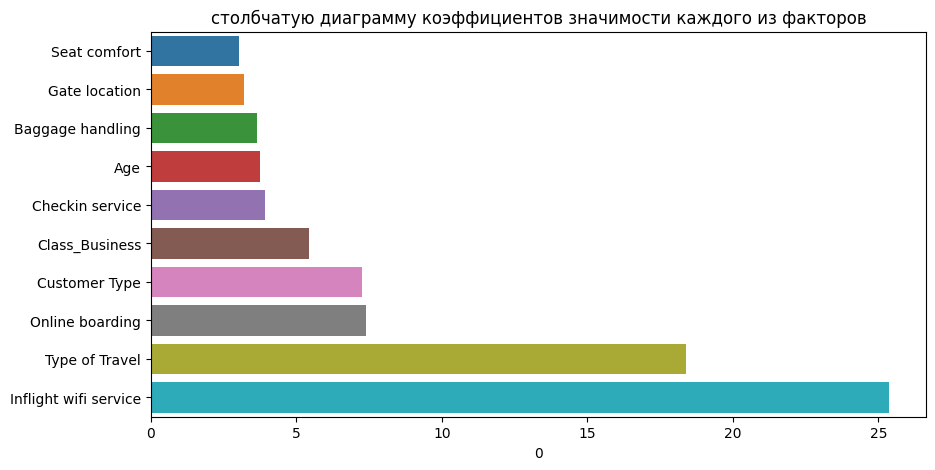

In [96]:
temp=model_cat.feature_importances_

df=pd.DataFrame(temp, index=X.columns)
df=df[0].sort_values().tail(10)

fig = plt.figure(figsize=(10, 5))
fig = sns.barplot(x=df,y=df.index)
# plt.xticks(rotation=45)
fig.set_title("столбчатую диаграмму коэффициентов значимости каждого из факторов")

```Python
pd.DataFrame(
    {
        "feature_importance": model_cat.get_feature_importance(),
        "feature_names": Air_data.drop(columns="satisfaction").columns,
    }
).sort_values(by=["feature_importance"], ascending=False)
```

In [98]:
feature_names = [x for x in Air_data if x != 'satisfaction']
pd.DataFrame({'feat': feature_names,
              'coef': model_cat.feature_importances_}).sort_values(by='coef', ascending=False)

,feat,coef
6,Inflight wifi service,25.364737
4,Type of Travel,18.391876
11,Online boarding,7.401483
2,Customer Type,7.240564
22,Class_Business,5.420057
17,Checkin service,3.925791
3,Age,3.742350
16,Baggage handling,3.640798
9,Gate location,3.196286
12,Seat comfort,3.012455
